In [76]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [77]:
class MNSITDigitClassifier: 
    
    def __init__(
        self, 
        train_path = '/Users/sayar/Desktop/aiml/GROKKING DEEP LEARNING/MNSIT_FROM_SCRATCH/dataset_files/train.csv', 
        test_path = '/Users/sayar/Desktop/aiml/GROKKING DEEP LEARNING/MNSIT_FROM_SCRATCH/dataset_files/test.csv', 
        h1_nodes = 128,   # HIDDEN LAYER_1 NODES
        h2_nodes = 64, 
        lr = 0.05, 
        epochs = 30,
        batch_size = 128,
        val_ratio = 0.2,
        rand_seed = 42    
    ): 
        
        np.random.seed(rand_seed)

        # FILE PATHS--------
        self.train_path = train_path
        self.test_path = test_path

        # PARAMETERS--------
        self.input_size = 784      # LAYER_0
        self.output_size = 10      # LAYER_3
        self.h1_nodes = h1_nodes   # LAYER_1
        self.h2_nodes = h2_nodes   # LAYER_2
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.val_ratio = val_ratio

        # LAYER_0_1 WEIGHTS------
        self.weights_0_1 = np.random.randn(self.input_size, self.h1_nodes) * np.sqrt(2 / self.input_size)  # 784x128
        
        # LAYER_1_2 WEIGHTS------
        self.weights_1_2 = np.random.randn(self.h1_nodes, self.h2_nodes) * np.sqrt(2 / self.h1_nodes)      # 128x64
        
        # LAYER_2_3 WEIGHTS------
        self.weights_2_3 = np.random.randn(self.h2_nodes, self.output_size) * np.sqrt(2 / self.h2_nodes)    # 64x10
        
    
    def load_and_split_data(self):

        data = pd.read_csv(self.train_path)
        data_array = np.array(data) 
        
        X = data_array[0:,1:]    # PIXELS     42000x784
        Y = data_array[:,0].astype(int)     # LABELS   42000x1

        X = X / 255.0     # NORMALIZING
        
        n = X.shape[0]
        idx = np.random.permutation(n)
        
        val_size = int(n * self.val_ratio)    # 20 % VALIDATION DATA
        val_idx = idx[:val_size]
        train_idx = idx[val_size:]
        
        X_train, Y_train = X[train_idx], Y[train_idx]
        X_val, Y_val = X[val_idx], Y[val_idx]

        self.X_train = X_train   # 33600x784
        self.Y_train = Y_train   # 33600x1
        self.X_val = X_val       # 8400x784
        self.Y_val = Y_val       # 8400x1  

    def batchify_training_data(self):
        
        m = self.X_train.shape[0]
        batches = []
        
        for start in range(0,m,self.batch_size): 
            end = start + self.batch_size

            Xb_train = self.X_train[start:end]   # 128x784
            Yb_train = self.Y_train[start:end]   # 128x1
            batches.append((Xb_train,Yb_train))
            
        return batches   
        
    def batchify_validation_data(self): 
        
        m = self.X_val.shape[0]
        batches_validation = []
        
        for start in range(0,m,self.batch_size): 
            end = start + self.batch_size

            Xb_val = self.X_val[start:end]   # 128x784
            Yb_val = self.Y_val[start:end]   # 128x1
            batches_validation.append((Xb_val,Yb_val))
            
        return batches_validation
        
    def relu_forward(self,x):
        return np.maximum(0, x)

    def relu_backward(self,x): 
        return (x > 0).astype(float)

    def softmax(self,x): 
        
        x = x - np.max(x, axis=1, keepdims=True)
        exp_x = np.exp(x)

        
        return exp_x/np.sum(exp_x,axis=1,keepdims=True)

    def forward(self,xb): 
        
        layer_0 = xb   # INPUTS , 128x784  128=each batch size

        hidden_layer_1_raw = np.dot(layer_0,self.weights_0_1) # 128x784 , 784x128 == 128x128 
        hidden_layer_1 = self.relu_forward(hidden_layer_1_raw)     # CUTS OFF NEGATIVE VALUES TO 0

        hidden_layer_2_raw = np.dot(hidden_layer_1,self.weights_1_2)  # 128x128 , 128x64 == 128x64 
        hidden_layer_2 = self.relu_forward(hidden_layer_2_raw)   

        layer_3 = np.dot(hidden_layer_2,self.weights_2_3)     # 128x64 , 64x10 == 128x10 
        
        probs = self.softmax(layer_3)   # 1x10 

        return probs , hidden_layer_1_raw , hidden_layer_1 , hidden_layer_2 , hidden_layer_2_raw , layer_3 , layer_0
                
    def cross_entropy_loss(self,probs,yb): 

        B = probs.shape[0]
        correct_probs = probs[np.arange(B), yb]
        batch_loss = -np.mean(np.log(correct_probs + 1e-9))
        preds = np.argmax(probs,axis=1)
        batch_accuracy = np.mean(preds == yb) 

        return batch_loss , batch_accuracy , B

    def save_training_scores(self,batch_loss,batch_accuracy): 
        pass 

    def backward(self,yb,probs,B,hidden_layer_1_raw,hidden_layer_2_raw): 

        layer_3_delta = probs.copy()
        layer_3_delta[np.arange(B),yb] -= 1  # ONE HOT ENCODING
        layer_3_delta /= B  # 128x10 

        layer_2_d = np.dot(layer_3_delta , self.weights_2_3.T)   #  128x10 , 10x64 == 128x64 
        layer_2_delta = layer_2_d * self.relu_backward(hidden_layer_2_raw)  #  128x64 

        layer_1_d = np.dot(layer_2_delta , self.weights_1_2.T)   # 128x64 , 64x128 == 128x128  
        layer_1_delta = layer_1_d * self.relu_backward(hidden_layer_1_raw)

        return layer_1_delta , layer_2_delta , layer_3_delta      

    def update_weights(self , layer_1_delta , layer_2_delta , layer_3_delta , hidden_layer_1 , hidden_layer_2 , layer_0): 
        
        wd_3 = layer_3_delta                     # 128x10  
        
        wd_2_3 = (hidden_layer_2.T @ layer_3_delta) # 64x10 
        wd_1_2 = (hidden_layer_1.T @ layer_2_delta) # 128x64 
        wd_0_1 = (layer_0.T @ layer_1_delta)        # 784x128

        
        self.weights_2_3 -= self.lr * wd_2_3   # 64x10 
        self.weights_1_2 -= self.lr * wd_1_2   # 128x64 
        self.weights_0_1 -= self.lr * wd_0_1  # 784x128 

    def looping_training_batches(self):   # (FORWARD -> BACKWARD -> UPDATE WEIGHTS)   LOOP
        
        if not hasattr(self, "X_train"):
            self.load_and_split_data()
            
        epochs_idx_train = []
        epochs_loss_train = [] 
        epochs_accuracy_train = []
        
        epochs_idx_val = []
        epochs_loss_val = [] 
        epochs_accuracy_val = []
    
        for i in range(self.epochs): 

            # shuffle training data each epoch
            perm = np.random.permutation(self.X_train.shape[0])
            self.X_train = self.X_train[perm]
            self.Y_train = self.Y_train[perm]

            batches = self.batchify_training_data()
    
            total_losses_train = [] 
            total_accuracy_train = []
    
            for batch_idx,(xb,yb) in enumerate(batches): 
    
                probs , hid_l1_raw , hid_l1 , hid_l2 , hid_l2_raw , l_3 , l_0 = self.forward(xb)
                batch_loss , batch_accuracy , b = self.cross_entropy_loss(probs , yb)
                
                total_losses_train.append(batch_loss)
                total_accuracy_train.append(batch_accuracy)
            
                l1_delta , l2_delta , l3_delta = self.backward(yb , probs , b , hid_l1_raw , hid_l2_raw)
                
                self.update_weights(l1_delta , l2_delta , l3_delta , hid_l1 , hid_l2 , l_0) 

            avg_batch_loss = np.mean(total_losses_train)
            avg_batch_accuracy = np.mean(total_accuracy_train)
            
            epochs_loss_train.append(avg_batch_loss)
            epochs_accuracy_train.append(avg_batch_accuracy)
            epochs_idx_train.append(i+1)
            
            avg_val_loss , avg_val_acc = self.evaluating_validation()

            epochs_loss_val.append(avg_val_loss)
            epochs_accuracy_val.append(avg_val_acc)
            epochs_idx_val.append(i+1)
                        
            '''print(f"Epoch : {i+1}\n")
            
            print(f"Training Loss: {avg_batch_loss:.4f}")
            print(f"Training Accuracy: {avg_batch_accuracy:.4f}\n")

            print(f"Validation Loss : {avg_val_loss:.4f}")
            print(f"Validation Accuracy : {avg_val_acc:.4f}\n")'''
            
        overall_loss_train = np.mean(epochs_loss_train)
        overall_accuracy_train = np.mean(epochs_accuracy_train)

        overall_loss_val = np.mean(epochs_loss_val)
        overall_accuracy_val = np.mean(epochs_accuracy_val)
 
        print(f"Average Training Loss : {overall_loss_train:.4f}")
        print(f"Average Training Accuracy : {overall_accuracy_train:.4f}\n")
        
        print(f"Average Validation Loss : {overall_loss_val:.4f}")
        print(f"Average Validation Accuracy : {overall_accuracy_val:.4f}")
    
        return (epochs_idx_train , epochs_loss_train ,epochs_accuracy_train , epochs_idx_val ,
                                                                            epochs_loss_val , epochs_accuracy_val)

    def generate_training_dataframe(self , epochs_idx_train , epochs_loss_train , epochs_accuracy_train): 
        
        training_data = pd.DataFrame({
            "Epoch" : epochs_idx_train , 
            "Loss" : epochs_loss_train , 
            "Accuracy" : epochs_accuracy_train
        }) 

        return training_data
        
    def generate_validation_dataframe(self , epochs_idx_val , epochs_loss_val , epochs_accuracy_val): 
        
        validation_data = pd.DataFrame({
            "Epoch" : epochs_idx_val , 
            "Loss" : epochs_loss_val , 
            "Accuracy" : epochs_accuracy_val
        }) 

        return validation_data

    def evaluating_validation(self):  

        batches_validation = self.batchify_validation_data()
        
        total_losses_val = [] 
        total_accuracy_val = []

        for batch_idx_v,(xb_v,yb_v) in enumerate(batches_validation): 
        
            probs , hid_l1_raw , hid_l1 , hid_l2 , hid_l2_raw , l_3 , l_0 = self.forward(xb_v)
            batch_loss_v , batch_accuracy_v , b = self.cross_entropy_loss(probs , yb_v) 
        
            total_losses_val.append(batch_loss_v)
            total_accuracy_val.append(batch_accuracy_v)

        avg_val_loss = np.mean(total_losses_val)
        avg_val_acc = np.mean(total_accuracy_val)
    
        return avg_val_loss , avg_val_acc

    def plot_data(self): 
        
        plt.figure(figsize=(10,5))

        plt.plot(train_df.index,train_df['Accuracy'],label = 'Training',color = 'blue',linestyle = '--')
        plt.plot(train_df.index,val_df['Accuracy'],label = 'Validation',color = 'red',linestyle = '--')
        
        plt.xlabel('Epoches')
        plt.ylabel('Accuracy')
        plt.title('Training Vs Validation Accuracy Scores')
        plt.legend() 
        plt.grid(True)
        plt.show()   
    
    def load_test_data(self):     # NEED ONLY FOR KAGGLE SUBMISSION AT 
        tst = pd.read_csv(self.test_path)
        tst_array = np.array(tst)    
        X_test = tst_array       # 42000x784
        return X_test 
        
        

Average Training Loss : 0.1281
Average Training Accuracy : 0.9644

Average Validation Loss : 0.1498
Average Validation Accuracy : 0.9563


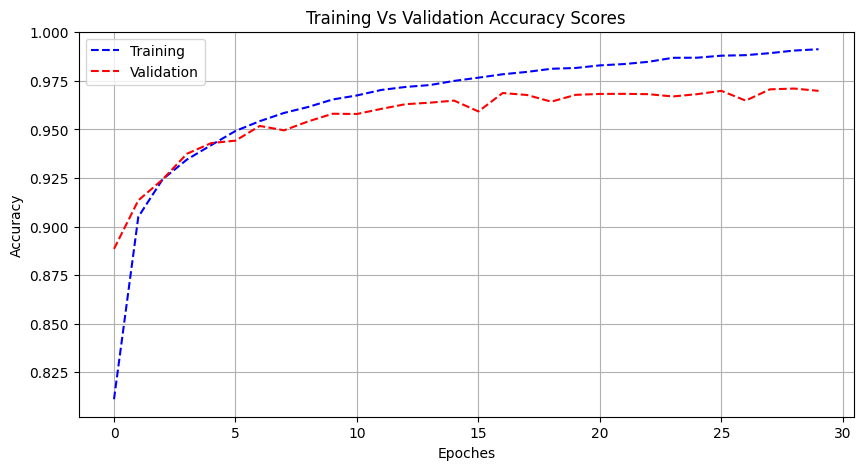

In [78]:
model = MNSITDigitClassifier() 

model.load_and_split_data()  

e_t, l_t, a_t, e_v, l_v, a_v = model.looping_training_batches()

train_df = model.generate_training_dataframe(e_t, l_t, a_t)
val_df = model.generate_validation_dataframe(e_v, l_v, a_v)

model.plot_data()